## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

## Baseline Parameters

In [2]:
S0 = 35
sigma = 0.4
r = 0.01
K = 35
q = 0.03
T = 1

## Task 1: Black Scholes

### Black Scholes

In [3]:
def black_scholes_call(S0, sigma, r, q, K, T):
    d1 = (np.log(S0 / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * np.exp(-q * T) * stats.norm(0, 1).cdf(d1) - K * np.exp(-r * T) * stats.norm(0, 1).cdf(d2)

def black_scholes_put(S0, sigma, r, q, K, T):
    d1 = (np.log(S0 / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * stats.norm(0, 1).cdf(-d2) - S0 * np.exp(-q * T) * stats.norm(0, 1).cdf(-d1)

In [4]:
p = black_scholes_put(S0, sigma, r, q, K, T)

In [5]:
p

5.788371914985477

### Put-Call Parity

In [6]:
def find_call(S0, r, q, K, T, p):
    return p + S0 - K * np.exp((q-r) * T)

In [7]:
c = find_call(S0, r, q, K, T, p)

In [8]:
c

5.081325014049021

## Task 2: Binomial Tree

In [9]:
def binomial_tree_fast(S0, sigma, r, q, K, T, n):
    
    # precompute constants
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma *  np.sqrt(dt))
    p = (np.exp((r - q) * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # initialise asset prices at maturity - Time step N
    ST = S0 * d ** (np.arange(n, -1, -1)) * u ** (np.arange(0, n + 1, 1))

    # initialise option values at maturity
    ST = np.maximum(K - ST, np.zeros(n + 1))

    # step backwards through tree
    for i in np.arange(n, 0, -1):
        ST = disc * (p * ST[1:i+1] + (1 - p) * ST[0:i])
    return ST[0]

In [10]:
data = []
for i in range(1, 1000):
    data.append(binomial_tree_fast(S0, sigma, r, q, K, T, i))

Text(0.5, 1.0, 'Binomial Tree Valuation')

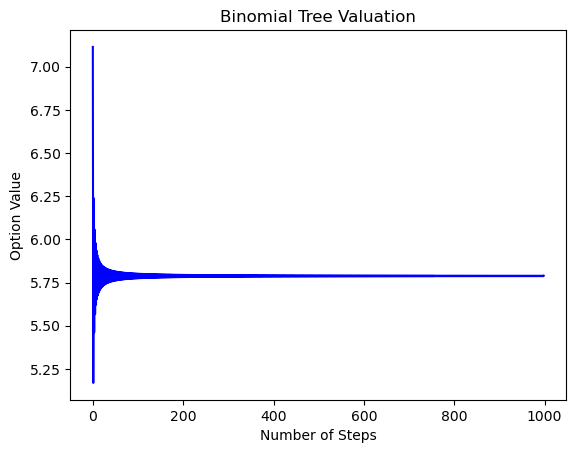

In [11]:
ax = sns.lineplot(data, color = 'blue')
ax.set(xlabel='Number of Steps', ylabel='Option Value')
ax.set_title('Binomial Tree Valuation')

In [12]:
pd.Series(data).to_csv('binomial_tree.csv')

## Task 3: Monte Carlo

### 3A: Plain Vanilla Option

In [13]:
def monte_carlo(S0, sigma, r, q, K, T, n):
    dist = stats.qmc.MultivariateNormalQMC(mean = [0], cov = [[1]])
    sample = dist.random(n)
    output = []
    for i in sample:
        ST = S0 * np.exp((r - q - sigma ** 2 / 2) * T + sigma * i[0] * np.sqrt(T))
        payoff = max(K - ST, 0) * np.exp(-r * T)
        output.append(payoff)
    return pd.Series(output)

In [14]:
result = monte_carlo(S0, sigma, r, q, K, T, 1000000)

C:\Users\cece\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Mean Value of the Simulation

In [15]:
np.mean(result)

5.788371806919008

Standard Error of the Simulation

In [16]:
np.std(result) * np.log(1000000) / np.sqrt(1000000)

0.09052950325989385

Histogram of the Monte Carlo Simulation

In [17]:
non_zero_result = []
for i in result:
    if i > 0:
        non_zero_result.append(i)

Text(0.5, 1.0, 'Monte Carlo Simulation Histogram (Excluding 0 Option Value)')

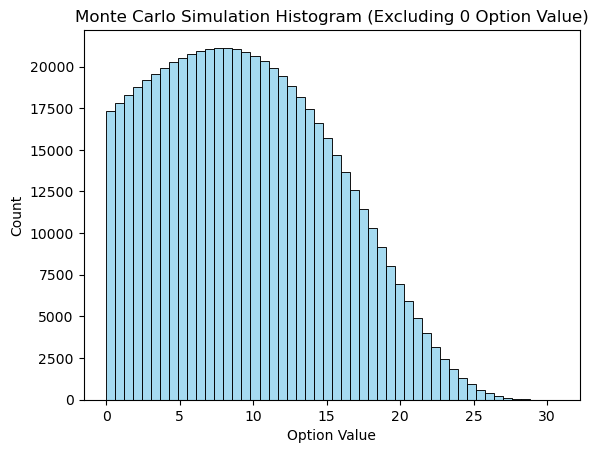

In [18]:
hist = sns.histplot(data = non_zero_result, bins = 50, color = 'skyblue')
hist.set(xlabel='Option Value', ylabel='Count')
hist.set_title('Monte Carlo Simulation Histogram (Excluding 0 Option Value)')

### 3B: Underlying asset and risk-free rate GBM

In [19]:
dist = stats.qmc.MultivariateNormalQMC(mean = [0, r], cov = [[1, 0.1], [0.1, 0.01]])

In [20]:
dist.random(10)

C:\Users\cece\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


array([[ 8.61651404e-03,  1.08616514e-02],
       [-1.13767019e+00, -1.03767019e-01],
       [ 1.28117180e+00,  1.38117180e-01],
       [-6.00293331e-01, -5.00293331e-02],
       [ 9.98570463e-01,  1.09857046e-01],
       [-8.79828949e-02,  1.20171051e-03],
       [ 5.08567249e-01,  6.08567249e-02],
       [-1.48743963e+00, -1.38743963e-01],
       [ 1.55440816e+00,  1.65440816e-01],
       [-4.78545252e-01, -3.78545252e-02]])

In [21]:
def monte_carlo2(S0, sigma, r, q, K, T, n):
    dist = stats.qmc.MultivariateNormalQMC(mean = [0, r], cov = [[1, -0.03], [-0.03, 0.01]])
    sample = dist.random(n)
    output = []
    for i in range(n):
        ST = S0 * np.exp((sample[i][1] - q - sigma ** 2 / 2) * T + sigma * sample[i][0] * np.sqrt(T))
        payoff = max(K - ST, 0) * np.exp(-sample[i][1] * T)
        output.append(payoff)
    return pd.Series(output)

In [22]:
result2 = monte_carlo2(S0, sigma, r, q, K, T, 1000000)

In [23]:
result2

0         14.883817
1          0.000000
2          4.040152
3          4.331793
4          9.154909
            ...    
999995     7.059150
999996    12.245597
999997     2.220927
999998     0.000000
999999     7.203472
Length: 1000000, dtype: float64

Mean Value of the Simulation

In [24]:
np.mean(result2)

5.6523188609571395

Standard Error of the Simulation

In [25]:
np.std(result2) * np.log(1000000) / np.sqrt(1000000)

0.08856866130724804

### 3C: Exotic Option

In [26]:
def monte_carlo3(S0, sigma, r, q, K, T, n, step):
    dist = stats.qmc.MultivariateNormalQMC(mean = [0], cov = [[1]])
    dt = T / step
    output = []
    for i in range(n):
        ST = S0
        sample = dist.random(step)
        is_below_30 = 0
        for j in range(step):
            ST = ST * np.exp((r - q - sigma ** 2 / 2) * dt + sigma * sample[j][0] * np.sqrt(dt))
            if ST < 30:
                is_below_30 = 1
                break
        if is_below_30:
            payoff = 0
        else:
            payoff = max(K - ST, 0) * np.exp(-r * T)
        output.append(payoff)
    return pd.Series(output)

In [28]:
result3 = monte_carlo3(S0, sigma, r, q, K, T, 1000, 10)

In [29]:
result3

0      0.000000
1      0.000000
2      0.000000
3      1.641534
4      0.000000
         ...   
995    1.445818
996    0.000000
997    0.000000
998    0.000000
999    0.000000
Length: 1000, dtype: float64

Mean Value of the Simulation

In [30]:
np.mean(result3)

0.3725224745575451

Standard Error of the Simulation

In [32]:
np.std(result) * np.log(1000) / np.sqrt(1000)

1.4313971287245142

## Task 4: Alternative Stochastic Process

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

# Define parameters
S0 = 35
r = 0.01
T = 1
kappa = 2  # mean reversion speed
theta = 0.4  # long-run variance
sigma = 0.4  # implied volatility
rho = -0.3  # correlation between the stock price and volatility
V0 = sigma**2  # initial variance
K = 35  # strike price
N = 1000  # number of simulation paths
M = 500  # number of time steps
dt = T / M  # time step size

# Define the function for the Heston model
def heston(s0, v0, kappa, theta, sigma, rho, r, T, M, N):
    # Initialize arrays
    S = np.zeros((M + 1, N))
    V = np.zeros((M + 1, N))
    S[0, :] = s0
    V[0, :] = v0

    # Generate correlated Brownian motions
    z1 = np.random.normal(size=(M, N))
    z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(M, N))

    # Generate stock price and volatility paths
    for t in range(1, M + 1):
        # Calculate the drift and volatility
        drift = r * S[t - 1, :]
        vol = np.sqrt(V[t - 1, :])

        # Update the stock price and volatility
        S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z1[t - 1, :])
        V[t, :] = np.maximum(
            0.0, V[t - 1, :] + kappa * (theta - V[t - 1, :]) * dt + sigma * np.sqrt(V[t - 1, :]) * np.sqrt(dt) * z2[t - 1, :]
        )

    # Calculate the option payoff at maturity
    payoff = np.maximum(K - S[-1, :], 0)

    # Calculate the option value using the LSM method
    for t in range(M - 1, 0, -1):
        # Calculate the cash flows and exercise values
        cash_flows = np.zeros(N)
        exercise_values = np.zeros(N)
        for i in range(N):
            if payoff[i] > 0:
                cash_flows[i] = payoff[i] * np.exp(-r * (T - t) / (M - t))
                exercise_values[i] = payoff[i]

        # Calculate the continuation values
        x = np.log(S[t, :] / K)
        y = np.sqrt(V[t, :])
        X = np.column_stack((np.ones(N), x, x ** 2, x ** 3, x ** 4))
        X_inv = np.linalg.inv(np.dot(X.T, X))
        beta = np.dot(X_inv, np.dot(X.T, cash_flows))
        continuation_values = np.dot(X, beta)

        # Determine the optimal exercise policy
        early_exercise = exercise_values > continuation_values
        payoff[early_exercise] = exercise_values[early_exercise]

    # Calculate the option value using Monte Carlo simulation
    discount_factor = np.exp(-r * T)
    option_value = discount_factor * np.mean(payoff)

    return option_value

# Value the American-style option using the Heston model and Monte Carlo simulation
option_value = heston(S0, V0, kappa, theta, sigma, rho, r, T, M, N)
print("Option value: ", option_value)

# # Generate a 4D graph of the Heston model paths
# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.set_title("Heston Model Paths")
# ax.set_xlabel("Time")
# ax.set_ylabel("Stock Price")
# ax.set_zlabel("Volatility")
# S = np.zeros((M + 1, N))
# V = np.zeros((M + 1, N))
# S[0, :] = S0
# V[0, :] = V0
# z1 = np.random.normal(size=(M, N))
# z2 = rho * z1 + np.sqrt(1 - rho ** 2) * np.random.normal(size=(M, N))

# # Generate stock price and volatility paths
# for t in range(1, M + 1):
#     # Calculate the drift and volatility
#     drift = r * S[t - 1, :]
#     vol = np.sqrt(V[t - 1, :])

#     # Update the stock price and volatility
#     S[t, :] = S[t - 1, :] * np.exp((drift - 0.5 * vol**2) * dt + vol * np.sqrt(dt) * z1[t - 1, :])
#     V[t, :] = np.maximum(
#         0.0, V[t - 1, :] + kappa * (theta - V[t - 1, :]) * dt + sigma * np.sqrt(V[t - 1, :]) * np.sqrt(dt) * z2[t - 1, :]
#     )

# for i in range(10):
#     ax.plot(np.arange(M + 1), S[:, i], V[:, i])
# plt.show()

# # Print information about the simulation
# print("Parameters:")
# print("S0 = ", S0)
# print("r = ", r)
# print("T = ", T)
# print("kappa = ", kappa)
# print("theta = ", theta)
# print("sigma = ", sigma)
# print("rho = ", rho)
# print("V0 = ", V0)
# print("K = ", K)
# print("N = ", N)
# print("M = ", M)
# print("dt = ", dt)
# print("Option value: ", option_value)

Option value:  3.568480018885622


## Task 5: Finite Difference Method

### Implicit Method

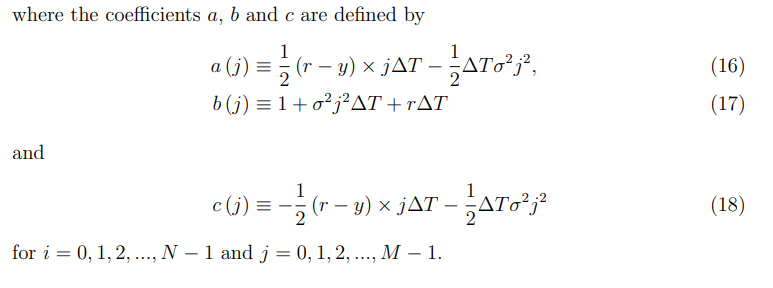

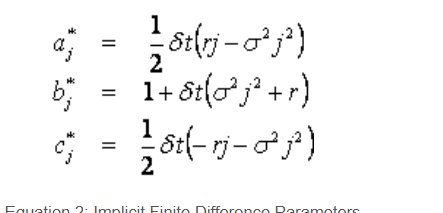

In [34]:
def finite_diff_implicit(S0, sigma, r, q, K, T, m, n):
    
    def a(r, q, dt, sigma, n):
        return 0.5 * dt * ((r-q)*n - (sigma * n) ** 2) / (1 - r * dt)

    def b(r, q, dt, sigma, n):
        return 1 + dt * ((sigma * n) ** 2) / (1 - r * dt)

    def c(r, q, dt, sigma, n):
        return 0.5 * dt * (-(r-q)*n - (sigma * n) ** 2) / (1 - r * dt)
    
    dt = T / m
    dS = 2 * S0 / n
    grid = np.zeros((m + 1, n + 1))
    S = np.arange(0, 2 * S0 + 0.1, dS)
    
    # Setting boundaries
    for i in range(m + 1):
        grid[i, 0] = K
    
    for j in range(n + 1):
        grid[m, j] = max(K - S[j], 0)
        
#     print(grid)
#     print(grid.shape)
        
    # Matrix A
    A = np.zeros((n-1, n-1))
    for i in range(n-1):
        if i != 0:
            A[i, i-1] = a(r, q, dt, sigma, i+1)
        elif i != n-1:
            A[i, i+1] = c(r, q, dt, sigma, i+1)
        A[i, i] = b(r, q, dt, sigma, i+1)
#     print(A)
#     print(A.shape)
    
    a0 = a(r, q, dt, sigma, 1)
    cn = c(r, q, dt, sigma, n-1)
    
    for i in range(m-1, -1, -1):
        f = grid[i+1, 1:-1]
        f[0] = f[0] - (a0 * grid[i, 0])
        f[-1] = f[-1] - (cn * grid[i, n])
        grid[i, 1:-1] = np.linalg.solve(A, f)
#         if i == m-1:
#             print(A)
#             print(b)
#             print(grid[i, :])
    if n % 2:
        return grid[0, n // 2]
    return grid[0, n // 2 - 1]

In [35]:
finite_diff_implicit(S0, sigma, r, q, K, T, 500, 64)

8.247424917085313e-07

### Explicit Method

In [36]:
def finite_diff_explicit(S0, sigma, r, q, K, T, m, n):
    dt = T / m
    dS = 2 * S0 / n
    grid = np.zeros((m + 1, n + 1))
    S = np.arange(0, 2 * S0 + 0.1, dS)
    
    # Setting boundaries
    for i in range(m + 1):
        grid[i, 0] = K
    
    for j in range(n + 1):
        grid[m, j] = max(K - S[j], 0)
        
    for i in range(m-1, -1, -1):
        for j in range(1, n):
            a = (-0.5 * (r - q) * j * dt + 0.5 * sigma ** 2 * j ** 2 * dt) / (1 + r * dt)
            b = (1 - sigma ** 2 * j ** 2 * dt) / (1 + r * dt)
            c = (0.5 * (r - q) * j * dt + 0.5 * sigma ** 2 * j ** 2 * dt) / (1 + r * dt)
            grid[i, j] = a * grid[i+1, j-1] + b * grid[i+1, j] + c * grid[i+1, j+1]
    
    if n % 2:
        return grid[0, n // 2]
    return grid[0, n // 2 - 1]

In [37]:
test = []
for i in range(1, 64):
    test.append(finite_diff_explicit(S0, sigma, r, q, K, T, 500, i))

Text(0.5, 1.0, 'Explicit Finite Difference (Converged)')

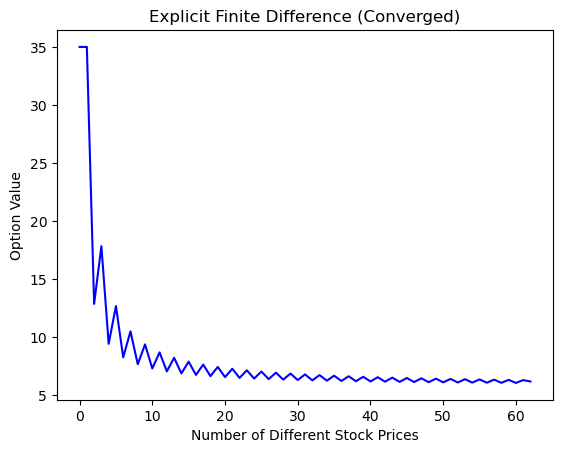

In [38]:
ax = sns.lineplot(test, color = 'blue')
ax.set(xlabel = 'Number of Different Stock Prices', ylabel = 'Option Value')
ax.set_title('Explicit Finite Difference (Converged)')

In [39]:
test2 = []
for i in range(1, 65):
    test2.append(finite_diff_explicit(S0, sigma, r, q, K, T, 500, i))

Text(0.5, 1.0, 'Explicit Finite Difference (Not Converged)')

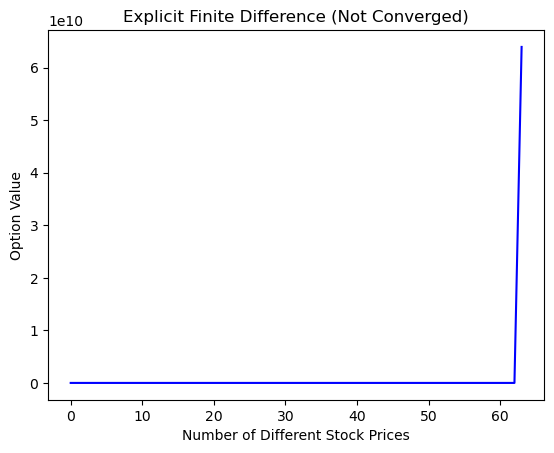

In [40]:
ax = sns.lineplot(test2, color = 'blue')
ax.set(xlabel = 'Number of Different Stock Prices', ylabel = 'Option Value')
ax.set_title('Explicit Finite Difference (Not Converged)')

## Task 6: Longstaff-Schwartz Least-Squares

In [41]:
def longstaff_schwartz(S0, sigma, r, q, K, T, m, n):
    dt = T / m
    df = np.exp(-r * dt)

    # Stock Price Paths
    S = S0 * np.exp(np.cumsum((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal((m+1, n)), axis=0))
    S[0] = S0

    # Inner Values
    h = np.maximum(K - S, 0)

    # Present Value Vector (Initialization)
    V = h[-1]

    # American Option Valuation by Backwards Induction
    for t in range(m - 1, 0, -1):
        rg = np.polyfit(S[t], V * df, 5)
        C  = np.polyval(rg, S[t])  # continuation values
        V  = np.where(h[t] > C, h[t], V * df)

    V0 = df * np.sum(V) / I  # LSM estimator

    return V0

In [46]:
I = 1000
longstaff_schwartz(S0, sigma, r, q, K, T, 500, 1000)

5.600780234465555